In [4]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from modeling import create_model

In [5]:
pbp = pd.read_parquet('data/pbp.parquet')
pbp['year'] = pbp['game_id'].apply(lambda x: int(x.split('_')[0]))
pbp['posteam'] = pbp['posteam'].bfill(limit=1)
pbp['defteam'] = pbp['defteam'].bfill(limit=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards',
       'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type',
       'defense_coverage_type', 'year'],
      dtype='object', length=393)


In [6]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_roll',
 'attempts_roll',
 'carries_roll',
 'passing_yards_roll',
 'rushing_yards_roll',
 'pass_pct_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [7]:
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['recent_team','season','week']).drop('recent_team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)
pbp.sample(5)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,carries_roll,passing_yards_roll,rushing_yards_roll,pass_pct_roll,completions_opp_roll,attempts_opp_roll,carries_opp_roll,passing_yards_opp_roll,rushing_yards_opp_roll,pass_pct_opp_roll
475092,2827.0,2019_11_NYJ_WAS,None,WAS,NYJ,REG,11,WAS,home,NYJ,...,22.142857,147.142857,102.142857,0.519476,23.857143,37.000000,27.428571,257.857143,75.000000,0.578326
105658,1166.0,2012_03_DET_TEN,2012092303,TEN,DET,REG,3,TEN,home,DET,...,15.857143,257.428571,47.714286,0.690571,27.142857,39.714286,24.428571,344.857143,104.571429,0.615267
418021,103.0,2018_08_MIA_HOU,None,HOU,MIA,REG,8,MIA,away,HOU,...,22.857143,245.285714,106.285714,0.580397,23.285714,35.857143,25.857143,255.857143,91.285714,0.567544
201133,2212.0,2014_01_CLE_PIT,2014090708,PIT,CLE,REG,1,CLE,None,PIT,...,22.857143,286.714286,105.428571,0.641417,22.571429,39.142857,24.142857,244.000000,112.571429,0.616118
459446,658.0,2019_05_MIN_NYG,None,NYG,MIN,REG,5,MIN,away,NYG,...,28.000000,203.714286,142.142857,0.489867,23.142857,35.000000,26.428571,318.857143,107.142857,0.571236


In [8]:
small = pbp.loc[pbp.year>2021].dropna(how='all',axis=1)
context_cols = ['play_id','game_id','home_team','away_team','game_half','posteam','side_of_field','desc']
small.loc[~small.down.isna()][context_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc
594875,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...
594876,89.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:29) (No Huddle, Shotgun) 19-J.Flacco pass ..."
594877,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to N...
594878,136.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:01) (No Huddle, Shotgun) 19-J.Flacco pass ..."
594879,172.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(13:53) 7-B.Mann punts 45 yards to BAL 19, Cen..."
...,...,...,...,...,...,...,...,...
726091,4158.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(1:18) (No Huddle, Shotgun) 5-J.Daniels pass s..."
726092,4183.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(:56) (No Huddle, Shotgun) 5-J.Daniels pass sh..."
726093,4217.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(:34) (No Huddle, Shotgun) 5-J.Daniels pass in..."
726094,4240.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(:31) (No Huddle, Shotgun) 5-J.Daniels pass sh..."


In [9]:
play_type_mapping = {
    'field_goal': 0,
    'no_play': 1,
    'pass': 2,
    'punt': 3,
    'qb_kneel': 4,
    'qb_spike': 5,
    'run': 6,
    np.nan: 7
}

In [10]:
x_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
] + team_stat_cols

small["play_type_enc"] = small['play_type'].map(play_type_mapping)
y_col = ["play_type_enc"]
data = small.loc[(~small.down.isna()) & (~small.rush_attempt.isna()) & ~(small.play_type.isna())][x_cols + y_col]
data = data.loc[~data.play_type_enc.isna()]


In [11]:
play_type_model = create_model(data, x_cols, y_col[0], colsample_bytree=0.8)
print(x_cols)


Accuracy: 0.67
Confusion Matrix:


array([[ 523,    8,   33,   10,    0,    1,   14],
       [  33,    1,  773,   59,    3,    0,  398],
       [  46,    5, 7894,   40,    3,    3, 2889],
       [   5,    8,   14, 1123,    0,    0,   12],
       [   0,    0,   18,    0,  193,    0,   16],
       [  10,    0,   33,    0,    0,    1,    0],
       [  11,    2, 2830,   27,   22,    1, 5030]], dtype=int64)

['yardline_100', 'down', 'goal_to_go', 'ydstogo', 'posteam_score', 'score_differential', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'wind', 'temp', 'spread_line', 'total_line', 'completions_roll', 'attempts_roll', 'carries_roll', 'passing_yards_roll', 'rushing_yards_roll', 'pass_pct_roll', 'completions_opp_roll', 'attempts_opp_roll', 'carries_opp_roll', 'passing_yards_opp_roll', 'rushing_yards_opp_roll', 'pass_pct_opp_roll']


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

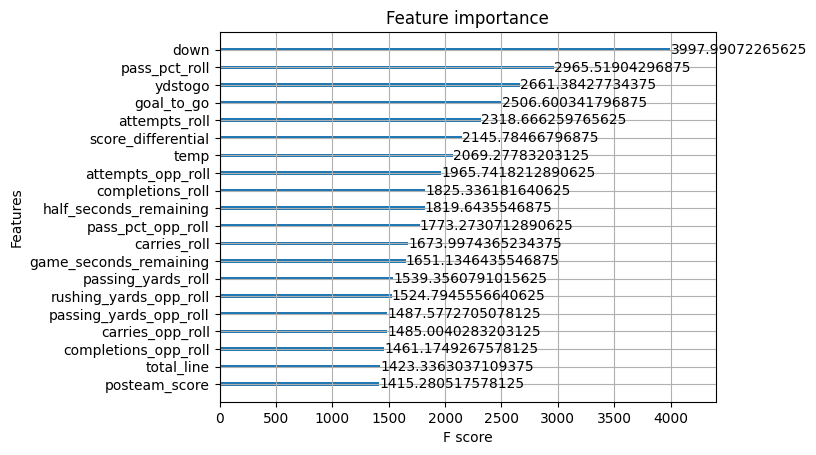

In [15]:
xgb.plot_importance(play_type_model,importance_type= 'cover', max_num_features=20)

In [19]:
joblib.dump(play_type_model, 'models/run_or_pass.joblib')

['models/run_or_pass.joblib']

In [21]:
{k:v for v,k in play_type_mapping.items()}

{0: 'field_goal',
 1: 'no_play',
 2: 'pass',
 3: 'punt',
 4: 'qb_kneel',
 5: 'qb_spike',
 6: 'run',
 7: nan}

In [22]:
feature_config = {
    'run_or_pass_cols':x_cols,
    'play_encoding': {k:v for v,k in play_type_mapping.items()}
}
feature_config

{'run_or_pass_cols': ['yardline_100',
  'down',
  'goal_to_go',
  'ydstogo',
  'posteam_score',
  'score_differential',
  'quarter_seconds_remaining',
  'half_seconds_remaining',
  'game_seconds_remaining',
  'wind',
  'temp',
  'spread_line',
  'total_line',
  'completions_roll',
  'attempts_roll',
  'carries_roll',
  'passing_yards_roll',
  'rushing_yards_roll',
  'pass_pct_roll',
  'completions_opp_roll',
  'attempts_opp_roll',
  'carries_opp_roll',
  'passing_yards_opp_roll',
  'rushing_yards_opp_roll',
  'pass_pct_opp_roll'],
 'play_encoding': {0: 'field_goal',
  1: 'no_play',
  2: 'pass',
  3: 'punt',
  4: 'qb_kneel',
  5: 'qb_spike',
  6: 'run',
  7: nan}}

In [23]:
with open("models/feature_config.yaml", "w") as file:
    yaml.dump(feature_config, file)

In [24]:
small.loc[small.play_type=='no_play'][['desc','first_down_penalty',
 'penalty',
 'penalty_team',
 'penalty_player_id',
 'penalty_player_name',
 'penalty_yards',
 'penalty_type',
 'drive_yards_penalized']].sample(10)

,desc,first_down_penalty,penalty,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,penalty_type,drive_yards_penalized
641789,"(11:04) PENALTY on LAC-88-T.McKitty, False Sta...",0.0,1.0,LAC,00-0037011,T.McKitty,5.0,False Start,-5.0
686843,"(6:43) (Shotgun) PENALTY on GB-95-D.Wyatt, Neu...",0.0,1.0,GB,00-0037075,D.Wyatt,5.0,Neutral Zone Infraction,5.0
724687,"(4:21) 17-B.Aubrey 64 yard field goal is GOOD,...",1.0,1.0,HOU,00-0033876,D.Barnett,15.0,Unnecessary Roughness,5.0
604101,Timeout #3 by NYG at 00:03.,0.0,0.0,None,None,None,NaN,None,0.0
611238,"(10:06) (Shotgun) PENALTY on GB, Delay of Game...",0.0,1.0,GB,None,None,5.0,Delay of Game,-15.0
689269,Timeout #1 by DAL at 11:53.,0.0,0.0,None,None,None,NaN,None,0.0
615522,"(7:47) PENALTY on NO-78-E.McCoy, False Start, ...",0.0,1.0,NO,00-0035242,E.McCoy,5.0,False Start,-5.0
661774,(5:23) 10-P.Walker pass short right to 85-D.Nj...,0.0,1.0,CLE,00-0034399,W.Teller,10.0,Offensive Holding,-10.0
604764,"(9:14) (No Huddle, Shotgun) 12-T.Brady pass sh...",0.0,1.0,TB,00-0033921,C.Godwin,10.0,Offensive Pass Interference,-20.0
611570,(8:24) 12-T.Brady pass incomplete short right....,0.0,1.0,TB,00-0036406,T.Wirfs,5.0,Ineligible Downfield Pass,5.0


In [21]:
small.head(5)[['desc','down','yards_gained']]

,desc,down,yards_gained
572973,GAME,NaN,NaN
572974,9-J.Tucker kicks 68 yards from BAL 35 to NYJ -...,NaN,0.0
572975,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...,1.0,19.0
572976,"(14:29) (No Huddle, Shotgun) 19-J.Flacco pass ...",1.0,0.0
572977,(14:25) (No Huddle) 32-Mi.Carter left end to N...,2.0,5.0


In [22]:
[x for x in small.columns if 'rush' in x.lower()]

['total_home_rush_epa',
 'total_away_rush_epa',
 'total_home_rush_wpa',
 'total_away_rush_wpa',
 'first_down_rush',
 'rush_attempt',
 'rush_touchdown',
 'lateral_rush',
 'rusher_player_id',
 'rusher_player_name',
 'rushing_yards',
 'lateral_rusher_player_id',
 'lateral_rusher_player_name',
 'lateral_rushing_yards',
 'rusher',
 'rusher_jersey_number',
 'rush',
 'rusher_id',
 'number_of_pass_rushers']

In [23]:
small.loc[(small.rusher_player_name=='S.Barkley')
          &
          (small.goal_to_go == 1)][['week','home_team','away_team','rusher_player_name','goal_to_go','yardline_100','yards_gained', 'ydstogo', 'rush', 'rushing_yards', 'rush_touchdown']].reset_index(drop=True)

,week,home_team,away_team,rusher_player_name,goal_to_go,yardline_100,yards_gained,ydstogo,rush,rushing_yards,rush_touchdown
0,1,TEN,NYG,S.Barkley,1,4.0,4.0,4.0,1.0,4.0,1.0
1,1,TEN,NYG,S.Barkley,1,3.0,2.0,3.0,1.0,2.0,0.0
2,2,NYG,CAR,S.Barkley,1,5.0,3.0,5.0,1.0,3.0,0.0
3,5,GB,NYG,S.Barkley,1,2.0,2.0,2.0,1.0,2.0,1.0
4,6,NYG,BAL,S.Barkley,1,10.0,5.0,10.0,1.0,5.0,0.0
5,6,NYG,BAL,S.Barkley,1,1.0,1.0,1.0,1.0,1.0,1.0
6,8,SEA,NYG,S.Barkley,1,2.0,1.0,2.0,1.0,1.0,0.0
7,8,SEA,NYG,S.Barkley,1,1.0,1.0,1.0,1.0,1.0,1.0
8,10,NYG,HOU,S.Barkley,1,11.0,2.0,11.0,1.0,2.0,0.0
9,10,NYG,HOU,S.Barkley,1,4.0,2.0,4.0,1.0,2.0,0.0


In [24]:
r_data = small.loc[small.rush==1]
r_data
rx_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    "total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
r_data[context_cols + rx_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc,yardline_100,down,...,posteam_score,total_away_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,temp,spread_line,total_line
572975,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...,78.0,1.0,...,0.0,0.0,0.0,896.0,1796.0,3596.0,NaN,NaN,-6.5,44.0
572977,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to N...,59.0,2.0,...,0.0,0.0,0.0,865.0,1765.0,3565.0,NaN,NaN,-6.5,44.0
572982,254.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(12:41) (Shotgun) 8-L.Jackson right tackle to ...,64.0,3.0,...,0.0,0.0,0.0,761.0,1661.0,3461.0,NaN,NaN,-6.5,44.0
572983,275.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(12:01) (Shotgun) 17-K.Drake right end to BAL ...,60.0,1.0,...,0.0,0.0,0.0,721.0,1621.0,3421.0,NaN,NaN,-6.5,44.0
572985,330.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(10:40) 17-K.Drake right tackle to BAL 49 for ...,52.0,3.0,...,0.0,0.0,0.0,640.0,1540.0,3340.0,NaN,NaN,-6.5,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698569,3722.0,2024_11_WAS_PHI,PHI,WAS,Half2,PHI,WAS,(4:50) 26-S.Barkley left guard to WAS 39 for 7...,46.0,1.0,...,19.0,10.0,9.0,290.0,290.0,290.0,NaN,NaN,4.5,49.5
698571,3751.0,2024_11_WAS_PHI,PHI,WAS,Half2,PHI,WAS,"(4:45) 26-S.Barkley right guard for 39 yards, ...",39.0,2.0,...,19.0,10.0,9.0,285.0,285.0,285.0,NaN,NaN,4.5,49.5
698580,4000.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(3:19) (No Huddle, Shotgun) 26-J.McNichols lef...",38.0,2.0,...,10.0,10.0,-16.0,199.0,199.0,199.0,NaN,NaN,4.5,49.5
698582,4052.0,2024_11_WAS_PHI,PHI,WAS,Half2,WAS,PHI,"(2:53) (No Huddle, Shotgun) 26-J.McNichols up ...",23.0,2.0,...,10.0,10.0,-16.0,173.0,173.0,173.0,NaN,NaN,4.5,49.5
